In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import math
import numpy as np

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Calculate Sharpe Funciton

$$ SharpeRatio = \frac{\mu -r_f }{\sigma} $$

N.B. For the below function I not taking out the risk free rate because all of the returns have already removed the risk free rate, thus they are already excess returns.  

In [3]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

# Alternative factors

* Multi asset value (VAL)
* Multi asset momentum (MOM)
* Quality minues Junk (QMJ)
* Beta against Beta (BAB)


Asness et al 2013 Value and Momentum Everywhere
Data available on AQR's webpage

In [4]:
data=pd.read_csv('AQR.csv',parse_dates=['DATE'], index_col=0)[['VAL','MOM','QMJ','BAB']]

# Fama French (1993) Three Factor Model

* Market
* SMB (Small minus Big)
* HML (High minus Low)

Available on Kenneth French's Dartmouth webpage

In [5]:
data=data.join(pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.)[['VAL', 'MOM', 'Mkt-RF', 'SMB', 'HML','QMJ','BAB']].dropna()
#data=data.join(pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.)[['VAL', 'MOM', 'Mkt-RF', 'SMB', 'HML','QMJ','BAB']].dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


# Data description

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


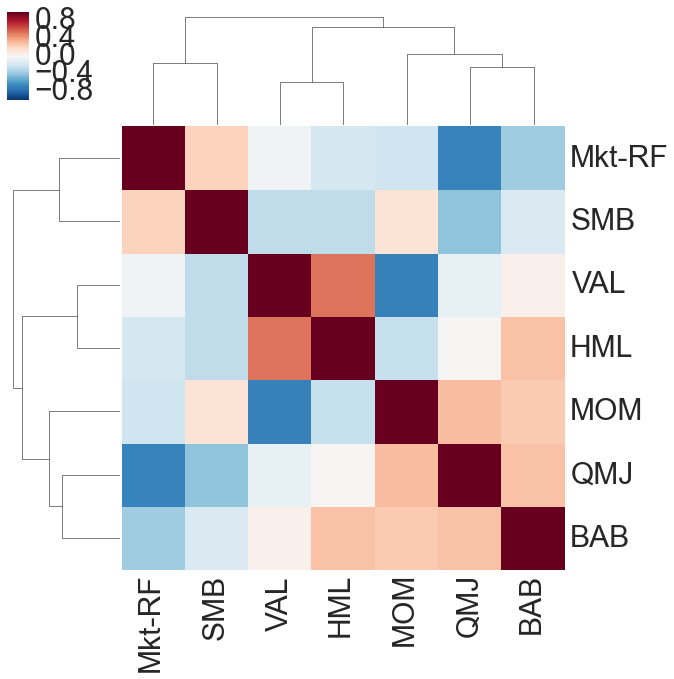

In [6]:
sns.clustermap(data.corr())

# 1/N Portoflio

$$ \frac{1}{N} \sum r_i $$

In [7]:
result=pd.DataFrame()
result['1/N']=data.mean(axis=1)

# 1/N Volatility scaled 

For each market returns are scaled by:
$$ \frac{r_t *volatilityTarget}{\sigma_{t-1}} $$


In [8]:
vol_target=.10
result['1/N Vol Scaled']=((data*vol_target)/(pd.ewmstd(data,24)*math.sqrt(12)).shift()).mean(axis=1)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=24).std(bias=False)
  


# Mean-Variance portoflio

 $$ \max_{x_t} \left [ \omega' \mu - \frac{\gamma}{2}\omega' \Sigma \omega \right ] $$
 
 Solving for the first order condition (FOC), we get:
 
 $$ \omega = \frac{1}{\gamma} \Sigma^{-1} \mu $$

In [9]:
sigma=data.cov().values
mu=data.mean().values
inverse = np.linalg.inv(sigma)
w=pd.Series(inverse.dot(mu),index=data.mean().index)

In [10]:
result['Ex-post Markowitz'] =(w*data).sum(axis=1)

# Min Variance

Assume the $\mu$ to all be the same

In [11]:
w_min_vol=pd.Series(inverse.dot(mu/mu),index=data.mean().index)

In [12]:
result['Ex-post Min-variance'] =(w_min_vol*data).sum(axis=1)

# Max Decorrelation


In [18]:
decorr_cov=sigma.copy()
np.fill_diagonal(decorr_cov,1)
decorr_inverse = np.linalg.inv(decorr_cov)
w_max_decorr=pd.Series(decorr_inverse.dot(mu/mu),index=data.mean().index)

In [22]:
result['Ex-post Max Decorrelation'] =(w_max_decorr*data).sum(axis=1)

# Ex-ante Markowitz

Window for the last three years to calculate weights for the next year

 $$ \max_{x_t} \left [ \omega' \hat{\mu_t}- \frac{\gamma}{2}\omega' \hat{\Sigma}_t \omega \right ] $$

In [15]:
months=50
s=pd.Series()
for i in data.dropna()[months:-1].index:
    cov=data[:i].tail(months).cov().values
    mu=data[:i].tail(months).mean().values
    inverse = np.linalg.inv(cov)
    w=pd.Series(inverse.dot(mu),index=data.mean().index)
    try:
        s[data.ix[i:].index[1]]=(data.ix[i:].ix[2]*w).sum()
    except:
        print i
result['Rolling 5 year Markowitz']=s   

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


2017-05-31 00:00:00


# Final Results

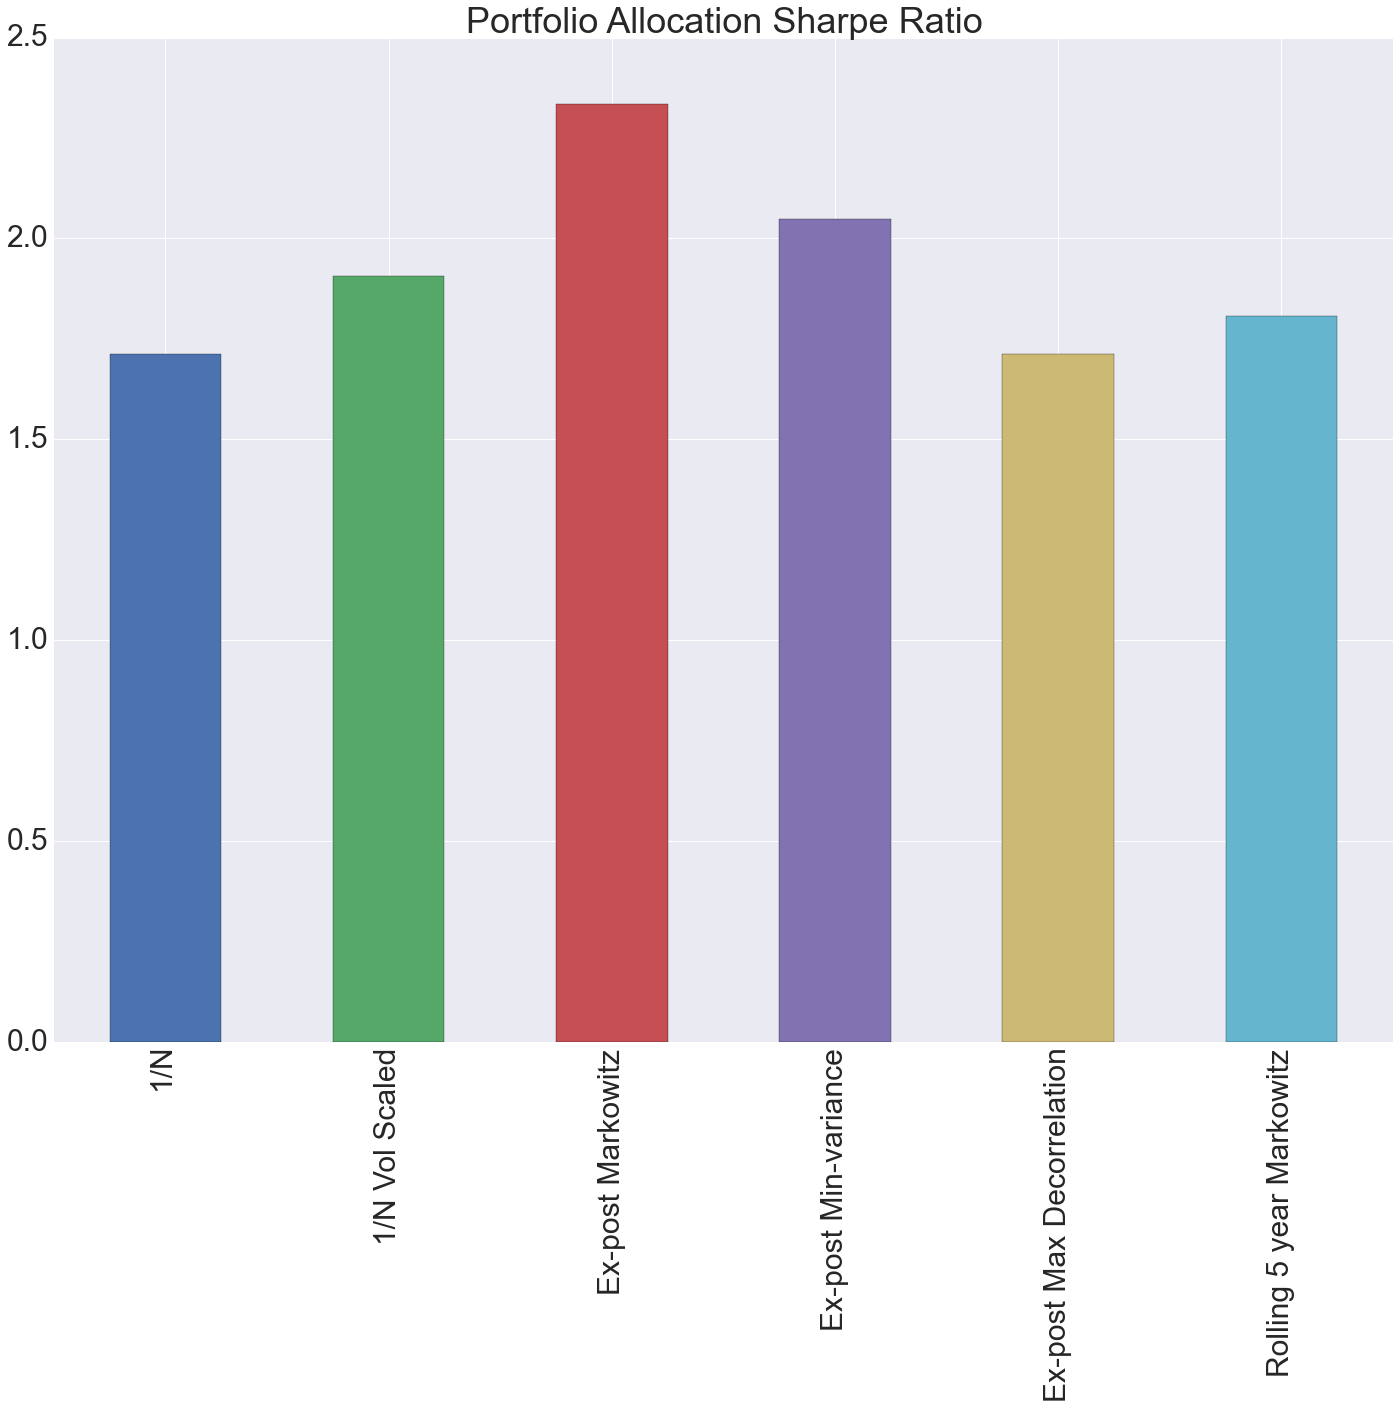

In [23]:
calc_Sharpe(result).plot(kind='bar',title='Portfolio Allocation Sharpe Ratio')

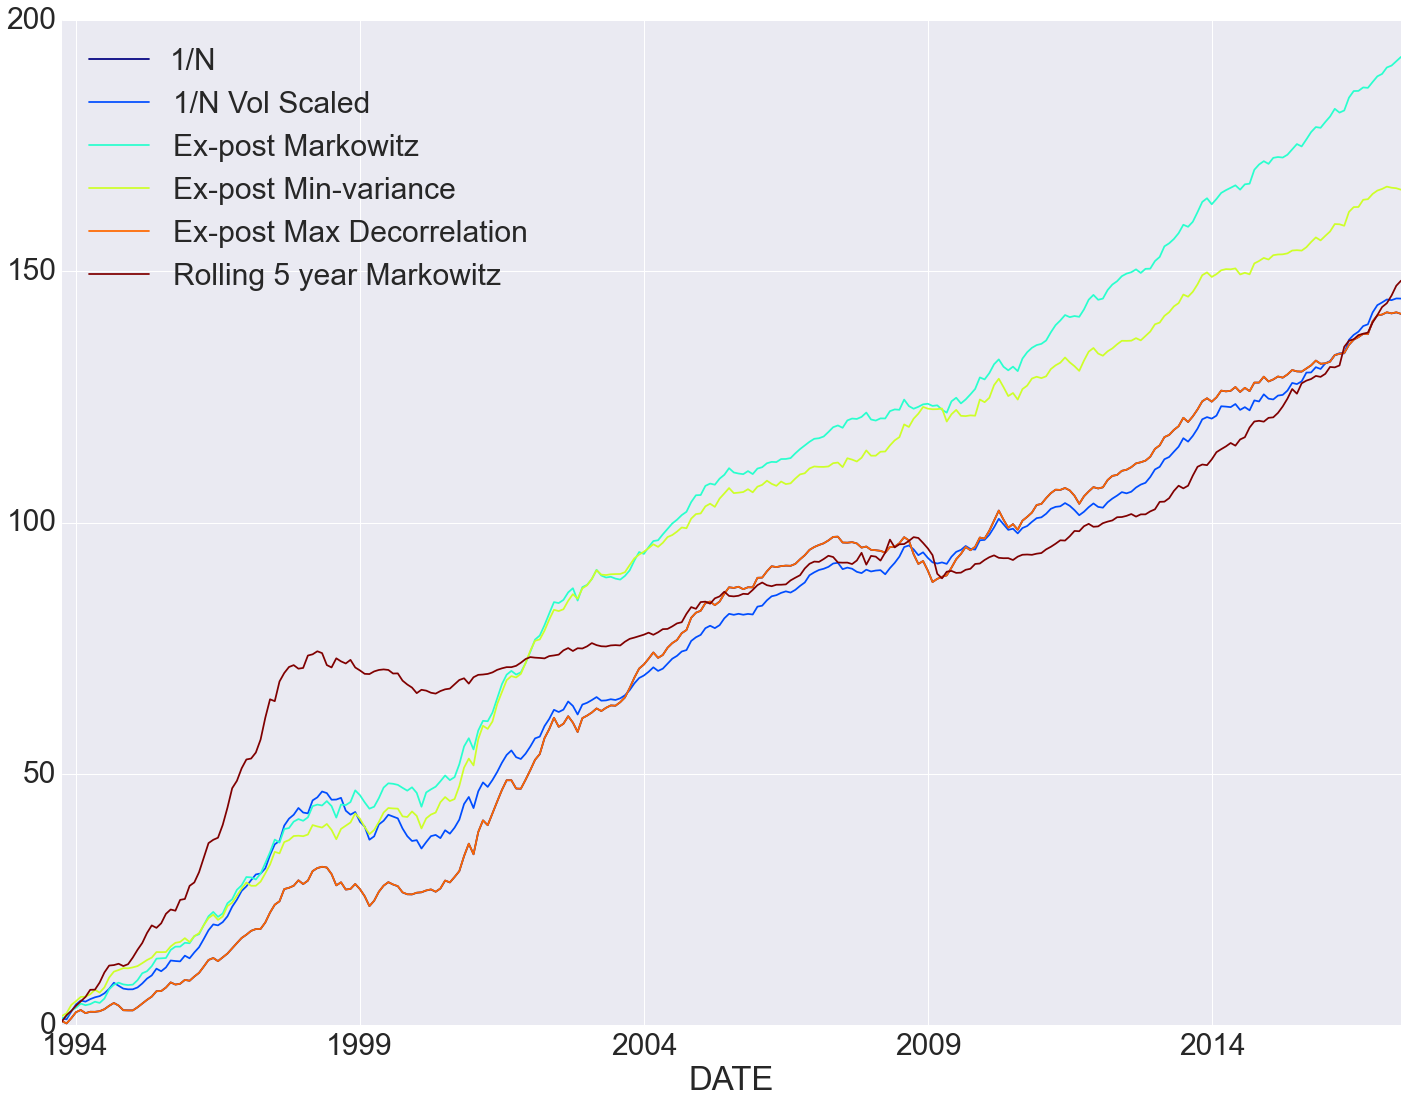

In [24]:
(result.dropna()/result.std()).dropna().cumsum().plot(colormap='jet')